# **CuPL**
This notebook performs zero-shot prediction using CLIP with the help of CuPL GPT-3 texts.<br>
Since there are lots of unrelated texts in CuPL, a new mechanism to filter out these texts by looking into text embeddings is implemented.<br>
Class name itself could also exist in these unrelated texts, making them impossible to filter by words.

# **Configurations**

In [1]:
# @title Colab Settings

# @markdown Whether to clone from our private repo, or manually put aml/ in our zip into /content/
colab_clone_repo = True     #@param {type:'boolean'}

In [2]:
# @title Hyperparameters For Filtering Outliers In CuPL Texts

# @markdown Minimum Mean Similarity Of Texts
similarity_mean_threshold = 0.7 #@param {type:'number'}

In [3]:
# @title Other Configurations

# @markdown Test On Which Dataset
test_dataset_name = 'caltech'   #@param ['airplane', 'caltech', 'dtd', 'flower', 'food', 'pets', 'ucf']
# test_dataset_name = 'airplane'
# test_dataset_name = 'caltech'
# test_dataset_name = 'dtd'
# test_dataset_name = 'flower'
# test_dataset_name = 'food'
# test_dataset_name = 'pets'
# test_dataset_name = 'ucf'

# @markdown Which CuPL Prompt To Use
cupl_prompt_type = 'full'       #@param ['full', 'base']
# cupl_prompt_type = 'full'
# cupl_prompt_type = 'base'

# **Prepare The Execution Environment**

In [4]:
# Change the path if necessary
datasets_path = 'datasets'

import sys
import os

# Deploy AML code in colab
if 'google.colab' in sys.modules:
    if colab_clone_repo and not os.path.exists('/content/applied-ml/'):
        !wget -q https://raw.githubusercontent.com/tsunrise/colab-github/main/colab_github.py
        import colab_github
        colab_github.github_auth(persistent_key=False)

        %cd /content/
        !git clone git@github.com:oz-e/applied-ml.git
        if not os.path.exists('/content/applied-ml/'):
            raise Exception('Please follow the instructions to add the SSH key to your account in order to clone private repo')

    if colab_clone_repo:
        %cd /content/applied-ml/
    else:
        %cd /content/

    # Install any other requirements (to be converted to requirements.txt)
    !pip install openai-clip

In [5]:
if not os.path.exists('CuPL'):
    !git clone https://github.com/sarahpratt/CuPL.git

In [6]:
import aml.datasets
import enum
import numpy as np
import torch
import clip
import json
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict
from CuPL.imagenet_prompts.standard_image_prompts import imagenet_templates
import sklearn.manifold
import sklearn.metrics

# **Processings**

## Create The CLIP Model And Dataset Object

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model, preprocess = clip.load('ViT-B/16', device=device, jit=False)

In [8]:
match test_dataset_name:
    case 'airplane':
        dataset_test = aml.datasets.FGVCAircraft(datasets_path, split='test')
        PATH_TO_PROMPTS = f'./CuPL/all_prompts/{cupl_prompt_type}_prompts/airplane_prompts_{cupl_prompt_type}.json'
    case 'caltech':
        dataset_test = aml.datasets.Caltech101(datasets_path, split='test')
        PATH_TO_PROMPTS = f'./CuPL/all_prompts/{cupl_prompt_type}_prompts/cal_prompts_{cupl_prompt_type}.json'
    case 'dtd':
        dataset_test = aml.datasets.DTD(datasets_path, split='test')
        PATH_TO_PROMPTS = f'./CuPL/all_prompts/{cupl_prompt_type}_prompts/texture_prompts_{cupl_prompt_type}.json'
    case 'flower':
        dataset_test = aml.datasets.Flowers102(datasets_path, split='test')
        PATH_TO_PROMPTS = f'./CuPL/all_prompts/{cupl_prompt_type}_prompts/flower_prompts_{cupl_prompt_type}.json'
    case 'food':
        dataset_test = aml.datasets.Food101(datasets_path, split='test')
        PATH_TO_PROMPTS = f'./CuPL/all_prompts/{cupl_prompt_type}_prompts/food_prompts_{cupl_prompt_type}.json'
    case 'pets':
        dataset_test = aml.datasets.OxfordIIITPet(datasets_path, split='test')
        if cupl_prompt_type != 'base':
            PATH_TO_PROMPTS = f'./CuPL/all_prompts/{cupl_prompt_type}_prompts/pets_prompts_{cupl_prompt_type}.json'
        else:
            PATH_TO_PROMPTS = f'./CuPL/all_prompts/{cupl_prompt_type}_prompts/pet_prompts_{cupl_prompt_type}.json'
    case 'ucf':
        dataset_test = aml.datasets.UCF101(datasets_path, split='test')
        PATH_TO_PROMPTS = f'./CuPL/all_prompts/{cupl_prompt_type}_prompts/ucf_prompts_{cupl_prompt_type}.json'

cls_names_sorted = dataset_test.classnames

## Calculate Text Features

### Text Features Using Class Name Directly

In [9]:
# Create class name features
with torch.no_grad():
    # label_ids of shape (num_classes,)
    cls_name_label_ids = np.arange(len(cls_names_sorted))

    # cls_name_features of shape (num_classes, 512)
    cls_name_features_cuda = model.encode_text(clip.tokenize(cls_names_sorted).to(device))
    cls_name_features_cuda /= cls_name_features_cuda.norm(dim=-1, keepdim=True)
    cls_name_features = cls_name_features_cuda.cpu().numpy()

    # Cosine similarity between text features of shape (num_classes, num_classes)
    # Fill diagonal to NaN since we don't want to compare the same class
    cls_name_masked_similarity = (cls_name_features_cuda @ cls_name_features_cuda.T).fill_diagonal_(float('nan')).cpu().numpy()

### Text Features Using 80 Templates

In [10]:
def calc_features(encoder, items_dict):
    # items_dict is a dict of list of items, where key is class id and value is a list of texts or images
    # encoder is a function that takes a list of items and returns their features
    with torch.no_grad():
        label_ids = []
        features_cuda = []
        cls_features_cuda = []
        for label_id in tqdm(range(len(cls_names_sorted))):
            # Use pop() to save memory when running on large datasets
            items = items_dict.pop(label_id)

            # label_ids list of size (num_classes), each containing (num_items,)
            label_ids.append([label_id] * len(items))

            # features_cuda list of size (num_classes), each containing (num_items, 512)
            class_embeddings = encoder(items)
            class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
            features_cuda.append(class_embeddings)

            # cls_features_cuda list of size (num_classes), each containing (512,)
            # Equivalent to the centroid of the class embeddings
            class_embedding = class_embeddings.mean(dim=0)
            class_embedding /= class_embedding.norm()
            cls_features_cuda.append(class_embedding)

        # label_ids becomes shape (num_classes * num_items,)
        label_ids = np.hstack(label_ids)
        # features becomes shape (num_classes * num_items, 512), corresponding to label_ids
        features = torch.vstack(features_cuda).cpu().numpy()
        # cls_features_cuda becomes shape (num_classes, 512)
        cls_features_cuda = torch.vstack(cls_features_cuda)

        # Cosine similarity between features of shape (num_classes, num_classes)
        # Fill diagonal to NaN since we don't want to compare the same class
        masked_similarity = (cls_features_cuda @ cls_features_cuda.T).fill_diagonal_(float('nan')).cpu().numpy()

    return label_ids, features, features_cuda, cls_features_cuda, masked_similarity

In [11]:
def encode_text(texts):
    with torch.no_grad():
        return model.encode_text(clip.tokenize(texts).to(device))

In [12]:
# Create template text features
template_label_texts_list = {label_id: [template.format(cls_name) for template in imagenet_templates] for label_id, cls_name in enumerate(cls_names_sorted)}
# template_label_ids: numpy shape (num_classes * num_templates,)
# template_text_features: numpy shape (num_classes * num_templates, 512)
# template_text_features_cuda: list size (num_classes), with cuda tensors shape (num_templates, 512). Same values as template_text_features
# template_cls_features_cuda: cuda tensors shape (num_classes, 512)
# template_masked_similarity: numpy shape (num_classes, num_classes)
template_label_ids, template_text_features, template_text_features_cuda, template_cls_features_cuda, template_masked_similarity = calc_features(encode_text, template_label_texts_list)

100%|██████████| 100/100 [00:01<00:00, 51.08it/s]


### Text Features Using Original CuPL (Unfiltered)

In [13]:
# Mapping between CuPL classes and dataset cls_name
match test_dataset_name:
    case 'caltech':
        special_class_mapping = {
            'centered face': 'face',
            'side of a car': 'car_side',
            'body of a cougar cat': 'cougar_body',
            'face of a cougar cat': 'cougar_face',
            'head of a crocodile': 'crocodile_head',
            'head of a flamingo': 'flamingo_head',
            'snoopy (cartoon beagle)': 'snoopy',
            'yin and yang symbol': 'yin_yang',
        }
    case 'flower':
        special_class_mapping = {
            'globe flower': 'globe-flower',
            'pink and yellow dahlia': 'pink-yellow dahlia',
            'air plant': 'ball moss',
        }
    case 'ucf':
        special_class_mapping = {
            'Hand Stand Pushups': 'Handstand_Pushups'
        }
    case _:
        special_class_mapping = {}

In [14]:
with open(PATH_TO_PROMPTS) as f:
    cupl_prompts_file = json.load(f)

# Lookup CuLP prompts from cls_name
original_cupl_prompts = {}
# Match label_id with cupl_cls_name
label_id_to_cupl_cls_name = {}

for cupl_cls_name, texts in cupl_prompts_file.items():
    cls_name = special_class_mapping.get(cupl_cls_name, cupl_cls_name)
    match test_dataset_name:
        case 'caltech' | 'dtd' | 'food' | 'ucf':
            cls_name = cls_name.replace(' ', '_')
        case 'pets':
            cls_name = cls_name.replace(' ', '_').lower()
    if cls_name not in cls_names_sorted:
        continue
    original_cupl_prompts[cls_name] = texts
    label_id_to_cupl_cls_name[cls_names_sorted.index(cls_name)] = cupl_cls_name

In [15]:
# Create original cupl text features
original_cupl_label_texts_list = {label_id: original_cupl_prompts[cls_name] for label_id, cls_name in enumerate(cls_names_sorted)}
# original_cupl_label_ids: numpy shape (num_classes * num_cupl_prompts,)
# original_cupl_text_features: numpy shape (num_classes * num_cupl_prompts, 512)
# original_cupl_text_features_cuda: list size (num_classes), with cuda tensors shape (num_cupl_prompts, 512). Same values as original_cupl_text_features
# original_cupl_cls_features_cuda: cuda tensors shape (num_classes, 512)
# original_cupl_masked_similarity: numpy shape (num_classes, num_classes)
original_cupl_label_ids, original_cupl_text_features, original_cupl_text_features_cuda, original_cupl_cls_features_cuda, original_cupl_masked_similarity = calc_features(encode_text, original_cupl_label_texts_list)

100%|██████████| 100/100 [00:00<00:00, 121.51it/s]


### Text Features Using Filtered CuPL
A new method is proposed to filter CuPL texts by comparing the text embeddings among others in the same class

In [16]:
# @title Filter Out Outliers In CuPL Text Features

with torch.no_grad():
    # Remove duplicates and calc text features
    unique_cupl_prompts = {label_id: list(dict.fromkeys(original_cupl_prompts[cls_name])) for label_id, cls_name in enumerate(cls_names_sorted)}
    # unique_cupl_text_features_cuda: list size (num_classes), with varying cuda tensors shape depending on number of unique cupl prompts
    _, _, unique_cupl_text_features_cuda, _, _ = calc_features(encode_text, unique_cupl_prompts.copy())

    # Filter by mean of similarity between texts of the same class
    # unique_cupl_text_similarity: list size (num_classes), with varying numpy shape in square shape
    # Fill diagonal to NaN since we don't want to compare the same text
    unique_cupl_text_similarity = [(features_cuda @ features_cuda.T).fill_diagonal_(float('nan')).cpu().numpy() for features_cuda in unique_cupl_text_features_cuda]
    # unique_cupl_text_similarity_mean: list size (num_classes), with varying vector length. Each number corresponds to each unique cupl prompt
    unique_cupl_text_similarity_mean = [np.nanmean(similarity, axis=0) for similarity in unique_cupl_text_similarity]
    # Do the actual filtering
    # unique_cupl_prompts: dict of list of texts, where key is class id and value is a list of texts after filtering
    filtered_cupl_prompts = {label_id: [text for text, similarity_mean in zip(texts, similarity_means) if similarity_mean >= similarity_mean_threshold] for (label_id, texts), similarity_means in zip(unique_cupl_prompts.items(), unique_cupl_text_similarity_mean)}

    # Print filtered prompts
    # outlier_cupl_prompts: just opposite of filtered_cupl_prompts
    outlier_cupl_prompts = {label_id: [(text, similarity_mean) for text, similarity_mean in zip(texts, similarity_means) if similarity_mean < similarity_mean_threshold] for (label_id, texts), similarity_means in zip(unique_cupl_prompts.items(), unique_cupl_text_similarity_mean)}
    # Find out which class has the most outliers
    top_filtered_label_id = None
    top_filtered_count = 0
    for label_id, texts_similarity in outlier_cupl_prompts.items():
        filtered_count = len(texts_similarity)
        if filtered_count != 0:
            print(f'Filtered {filtered_count} outliers for ({label_id}){cls_names_sorted[label_id]}')
            print(texts_similarity)
            print()
            if filtered_count > top_filtered_count:
                top_filtered_count = filtered_count
                top_filtered_label_id = label_id

100%|██████████| 100/100 [00:00<00:00, 137.92it/s]

Filtered 4 outliers for (1)leopard
[('This photo shows a leopard lounging in a tree.', 0.6655), ('The photo is of a leopard lying down on some rocks in a Savannah.', 0.687), ('Jaguar on the prowl in Pantanal, Brazil.', 0.568), ('This photo shows a leopard resting in a tree.', 0.6943)]

Filtered 1 outliers for (3)accordion
[('A man is playing an accordion in front of a brick building.', 0.672)]

Filtered 2 outliers for (4)airplane
[('A large metal airplane is sitting on a runway with its wheels down.', 0.6763), ('This photo is of a small, silver airplane flying through a blue sky.', 0.673)]

Filtered 1 outliers for (5)anchor
[('A neap tide frequency curve has how many phases?What is the capital of Yemen?.', 0.6294)]

Filtered 2 outliers for (6)ant
[('arctic glacierThe photo shows a large glacier in the Antarctic with a backdrop of mountains.', 0.4219), ('arctic expeditionThe photo is of a group of people in bulky coats and hats, standing on a sea of ice.', 0.497)]

Filtered 1 outliers f

In [17]:
# @title Print Filtered Outliers With Class Name In The Text
# @markdown Therefore it is difficult to auto filter outliers by checking the words in the text

import re
import inflect
p = inflect.engine()

outlier_cupl_prompts_with_cls_name = {}
for label_id, cupl_cls_name in sorted(label_id_to_cupl_cls_name.items()):
    outlier_texts_similarity = outlier_cupl_prompts[label_id]
    if len(outlier_texts_similarity) == 0:
        continue

    # List outlier_texts_similarity with class name in the text
    cls_name_set = set(
        cupl_cls_name.lower().replace('-', ' ').split() +
        p.plural(cupl_cls_name).lower().replace('-', ' ').split()
    )
    outlier_texts_with_cls_name = [text_similarity for text_similarity in outlier_texts_similarity if not cls_name_set.isdisjoint(re.findall(r'\b\w+\b|[^\w\s]', text_similarity[0].lower()))]
    if len(outlier_texts_with_cls_name) != 0:
        outlier_cupl_prompts_with_cls_name[label_id] = (cupl_cls_name, outlier_texts_with_cls_name)

for label_id, (cupl_cls_name, texts_similarity) in sorted(outlier_cupl_prompts_with_cls_name.items()):
    print(f'({label_id}){cupl_cls_name}: {len(texts_similarity)} outliers with class name in the text')
    print(texts_similarity)
    print()

(1)leopard: 3 outliers with class name in the text
[('This photo shows a leopard lounging in a tree.', 0.6655), ('The photo is of a leopard lying down on some rocks in a Savannah.', 0.687), ('This photo shows a leopard resting in a tree.', 0.6943)]

(3)accordion: 1 outliers with class name in the text
[('A man is playing an accordion in front of a brick building.', 0.672)]

(4)airplane: 2 outliers with class name in the text
[('A large metal airplane is sitting on a runway with its wheels down.', 0.6763), ('This photo is of a small, silver airplane flying through a blue sky.', 0.673)]

(7)barrel: 1 outliers with class name in the text
[(' raceA barrel race is a rodeo event in which a horse and rider attempt to complete a cloverleaf pattern around three barrels in the fastest time possible.', 0.674)]

(10)binocular: 1 outliers with class name in the text
[('The photo shows a pair of black binoculars on a green background.', 0.675)]

(12)brain: 1 outliers with class name in the text
[('T

#### Convert To Features

In [18]:
# Create filtered cupl text features
filtered_cupl_label_texts_list = {label_id: filtered_cupl_prompts[label_id] for label_id in range(len(cls_names_sorted))}
# Let 'n_texts' be the number of filtered texts in filtered_cupl_prompts, which is different for each class
# filtered_cupl_label_ids: numpy shape (num_classes * ('n_texts'),)
# filtered_cupl_text_features: numpy shape (num_classes * ('n_texts'), 512)
# filtered_cupl_text_features_cuda: list size (num_classes), with cuda tensors shape (('n_texts'), 512). Same values as filtered_cupl_text_features
# filtered_cupl_cls_features_cuda: cuda tensors shape (num_classes, 512)
# filtered_cupl_masked_similarity: numpy shape (num_classes, num_classes)
filtered_cupl_label_ids, filtered_cupl_text_features, filtered_cupl_text_features_cuda, filtered_cupl_cls_features_cuda, filtered_cupl_masked_similarity = calc_features(encode_text, filtered_cupl_label_texts_list)

100%|██████████| 100/100 [00:00<00:00, 140.64it/s]


### Outlier Visualization

Class: (1)leopard. Filtered 4 outliers:
(9)('This photo shows a leopard lounging in a tree.', 0.6655)
(11)('The photo is of a leopard lying down on some rocks in a Savannah.', 0.687)
(14)('Jaguar on the prowl in Pantanal, Brazil.', 0.568)
(15)('This photo shows a leopard resting in a tree.', 0.6943)


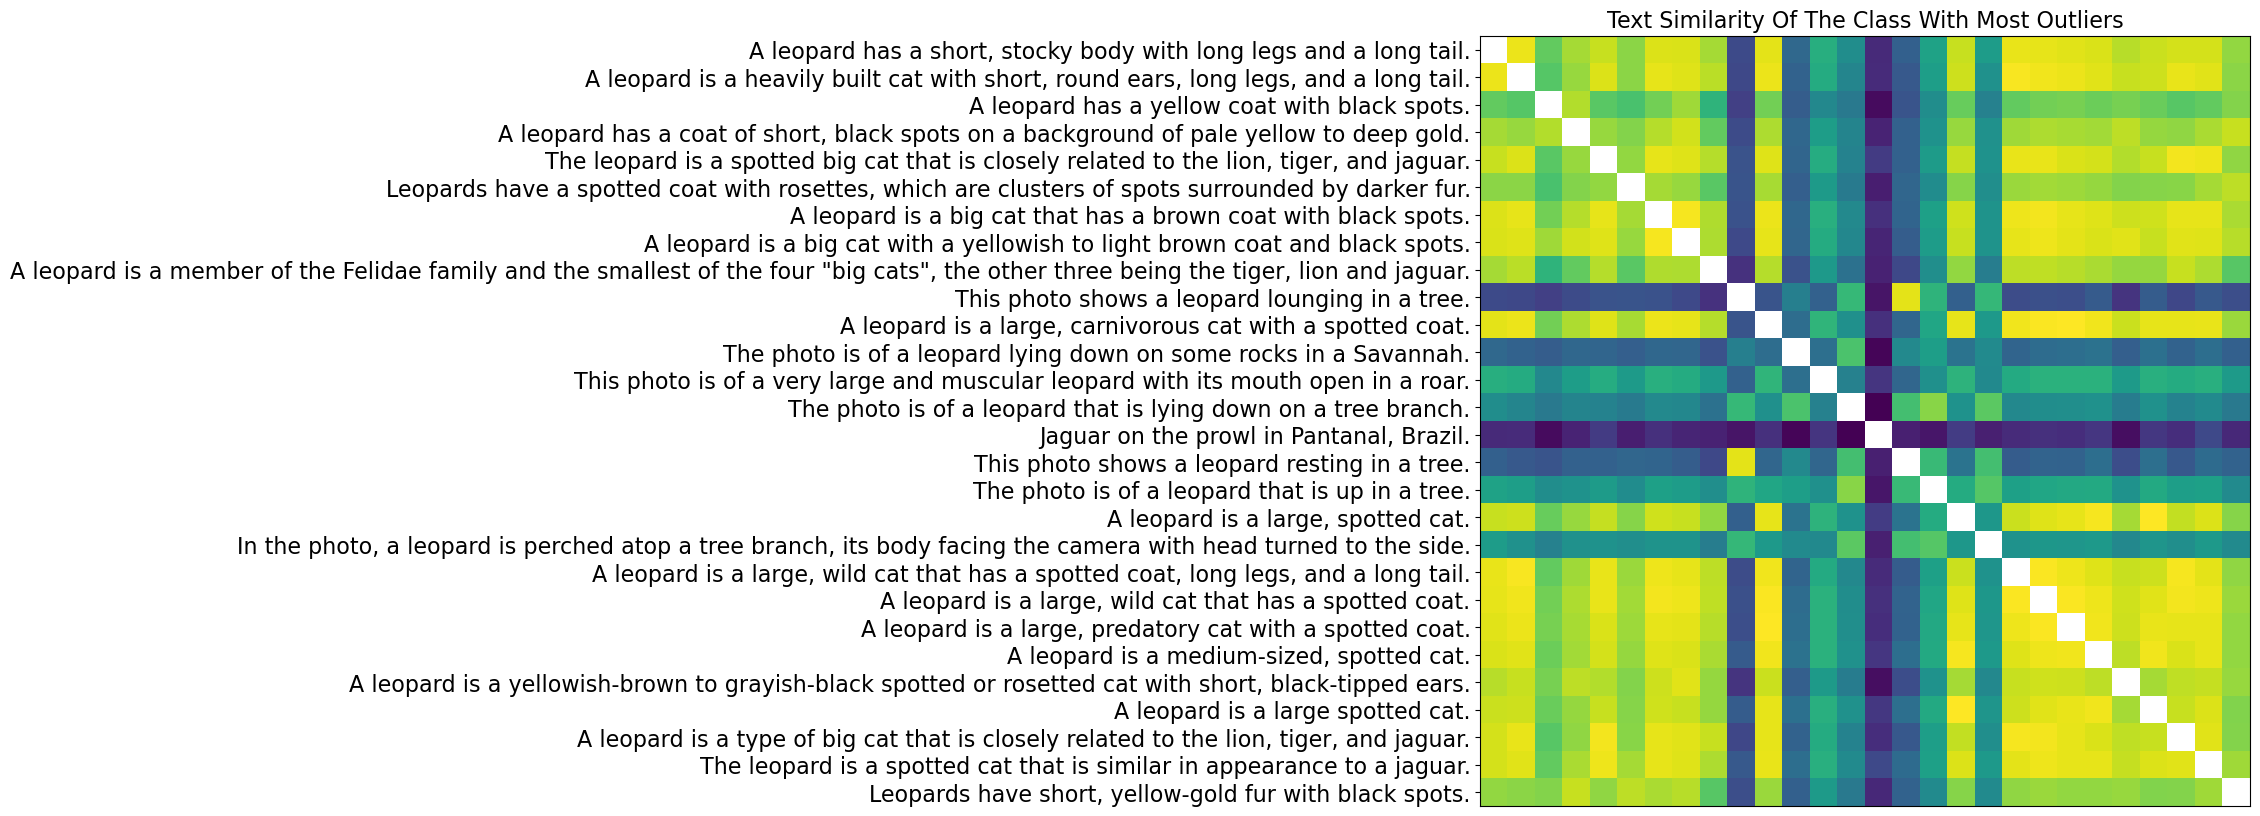

In [19]:
# @title Visualize Dis-similarity Of Outliers In CuPL

# @markdown Which class to show. Will show class with most outliers for invalid class ID
vis_label_id = -1   #@param {type:'integer'}

if vis_label_id < 0 or vis_label_id >= len(cls_names_sorted):
    vis_label_id = top_filtered_label_id
print(f'Class: ({vis_label_id}){cls_names_sorted[vis_label_id]}. Filtered {len(outlier_cupl_prompts[vis_label_id])} outliers:')
ylabels = unique_cupl_prompts[vis_label_id]
for text_similarity in outlier_cupl_prompts[vis_label_id]:
    print(f'({ylabels.index(text_similarity[0])}){text_similarity}')
plt.figure(figsize=(12, 10))
plt.imshow(unique_cupl_text_similarity[vis_label_id])
plt.xticks([])
plt.yticks(np.arange(0, len(ylabels)), ylabels, fontsize=16)
plt.title('Text Similarity Of The Class With Most Outliers', fontsize=16)
plt.show()

### Text Features Combining 80 Templates And CuPL

In [20]:
# Combine template text with cupl text features
# combined_original_cupl_text_features_cuda: list size (num_classes), with cuda tensors shape (num_templates + num_cupl_prompts, 512)
combined_original_cupl_text_features_cuda = [torch.vstack((text_features1, text_features2)) for text_features1, text_features2 in zip(template_text_features_cuda, original_cupl_text_features_cuda)]
# combined_filtered_cupl_text_features_cuda: list size (num_classes), with cuda tensors shape (num_templates + ('n_texts'), 512)
combined_filtered_cupl_text_features_cuda = [torch.vstack((text_features1, text_features2)) for text_features1, text_features2 in zip(template_text_features_cuda, filtered_cupl_text_features_cuda)]

# Calc centroid of text features
combined_original_cupl_cls_features_cuda = []
combined_filtered_cupl_cls_features_cuda = []
for class_embeddings in combined_original_cupl_text_features_cuda:
    class_embedding = class_embeddings.mean(dim=0)
    class_embedding /= class_embedding.norm()
    combined_original_cupl_cls_features_cuda.append(class_embedding)
for class_embeddings in combined_filtered_cupl_text_features_cuda:
    class_embedding = class_embeddings.mean(dim=0)
    class_embedding /= class_embedding.norm()
    combined_filtered_cupl_cls_features_cuda.append(class_embedding)
# combined_original_cupl_cls_features_cuda: cuda tensors shape (num_classes, 512)
combined_original_cupl_cls_features_cuda = torch.vstack(combined_original_cupl_cls_features_cuda)
# combined_filtered_cupl_cls_features_cuda: cuda tensors shape (num_classes, 512)
combined_filtered_cupl_cls_features_cuda = torch.vstack(combined_filtered_cupl_cls_features_cuda)

## Calculate Image Features

In [21]:
def encode_images(imgs):
    with torch.no_grad():
        return model.encode_image(torch.stack([preprocess(img) for img in imgs]).to(device))

In [22]:
# Create image features
imgs_grouped = defaultdict(list)
img_idx_grouped = defaultdict(list)
for img_idx, (img, label_id) in enumerate(dataset_test):
    imgs_grouped[label_id].append(img)
    img_idx_grouped[label_id].append(img_idx)

# Match img_idx corresponding to img_features_cuda after calc_features()
img_to_idx = [idx for label_id in range(len(cls_names_sorted)) for idx in img_idx_grouped[label_id]]

# Let 'n_imgs' be the number of images in each class, which is different for each class
# img_label_ids: numpy shape (num_classes * ('n_imgs'),)
# img_features_cuda: list size (num_classes), with cuda tensors shape (('n_imgs'), 512)
# img_masked_similarity: numpy shape (num_classes, num_classes)
img_label_ids, _, img_features_cuda, _, img_masked_similarity = calc_features(encode_images, imgs_grouped)

100%|██████████| 100/100 [00:08<00:00, 12.44it/s]


# **CLIP Zero-shot Predictions**

## Predictions Using Average Of Text Features

### Calculations

In [23]:
def calc_clip_pred(img_label_ids, img_features_cuda, text_features_cuda):
    with torch.no_grad():
        if type(text_features_cuda) == list:
            # list size (num_classes) of cuda tensors shape (texts in the class, 512)
            # Calc cosine similarity of each image with each text in the class, then take the mean
            logits = torch.vstack([(img_features_cuda @ embeddings.T).mean(dim=-1) for embeddings in text_features_cuda]).T
        else:
            # cuda tensor of shape (num_classes, 512)
            # Calc cosine similarity of each image with the centroid of the class
            logits = img_features_cuda @ text_features_cuda.T
        pred = logits.argmax(dim=-1).cpu().numpy()

        return (pred == img_label_ids).mean(), sklearn.metrics.confusion_matrix(img_label_ids, pred, labels=np.arange(len(cls_names_sorted)), normalize='true'), pred

In [24]:
# Zero-shot classification of CLIP
img_features_stacked_cuda = torch.vstack(img_features_cuda)

# Prediction using class name directly
cls_name_acc, cls_name_cm, cls_name_pred = calc_clip_pred(img_label_ids, img_features_stacked_cuda, cls_name_features_cuda)
# Prediction using text template (centroid)
template_cls_acc, template_cls_cm, template_cls_pred = calc_clip_pred(img_label_ids, img_features_stacked_cuda, template_cls_features_cuda)
# Prediction using text template (individual avg)
template_text_acc, template_text_cm, _ = calc_clip_pred(img_label_ids, img_features_stacked_cuda, template_text_features_cuda)
# Prediction using original CuPL text (centroid)
original_cupl_cls_acc, original_cupl_cls_cm, original_cupl_cls_pred = calc_clip_pred(img_label_ids, img_features_stacked_cuda, original_cupl_cls_features_cuda)
# Prediction using original CuPL text (individual avg)
original_cupl_text_acc, original_cupl_text_cm, _ = calc_clip_pred(img_label_ids, img_features_stacked_cuda, original_cupl_text_features_cuda)
# Prediction using filtered CuPL text (centroid)
filtered_cupl_cls_acc, filtered_cupl_cls_cm, filtered_cupl_cls_pred = calc_clip_pred(img_label_ids, img_features_stacked_cuda, filtered_cupl_cls_features_cuda)
# Prediction using filtered CuPL text (individual avg)
filtered_cupl_text_acc, filtered_cupl_text_cm, _ = calc_clip_pred(img_label_ids, img_features_stacked_cuda, filtered_cupl_text_features_cuda)
# Prediction using combined original CuPL text (centroid)
combined_original_cupl_cls_acc, _, _ = calc_clip_pred(img_label_ids, img_features_stacked_cuda, combined_original_cupl_cls_features_cuda)
# Prediction using combined original CuPL text (individual avg)
combined_original_cupl_text_acc, _, _ = calc_clip_pred(img_label_ids, img_features_stacked_cuda, combined_original_cupl_text_features_cuda)
# Prediction using combined filtered CuPL text (centroid)
combined_filtered_cupl_cls_acc, _, _ = calc_clip_pred(img_label_ids, img_features_stacked_cuda, combined_filtered_cupl_cls_features_cuda)
# Prediction using combined filtered CuPL text (individual avg)
combined_filtered_cupl_text_acc, _, _ = calc_clip_pred(img_label_ids, img_features_stacked_cuda, combined_filtered_cupl_text_features_cuda)

In [25]:
# Zero-shot classification of CLIP using one text on all images

# template_text_individual_features_cuda: list size (num_templates), with cuda tensors shape (num_classes, 512)
template_text_individual_features_cuda = list(torch.stack(template_text_features_cuda).permute(1, 0, 2))
# template_text_individual_acc: numpy shape (num_templates,), each containing the zero-shot accuracy of the text template
template_text_individual_acc = np.array([calc_clip_pred(img_label_ids, img_features_stacked_cuda, text_features_cuda)[0] for text_features_cuda in template_text_individual_features_cuda])
# template_text_individual_features_cuda: list size (num_templates + num_cupl_prompts), with cuda tensors shape (num_classes, 512)
original_cupl_text_individual_features_cuda = list(torch.stack(original_cupl_text_features_cuda).permute(1, 0, 2))
# original_cupl_text_individual_acc: numpy shape (num_templates + num_cupl_prompts,), each containing the zero-shot accuracy of the text template and CuPL prompt
original_cupl_text_individual_acc = np.array([calc_clip_pred(img_label_ids, img_features_stacked_cuda, text_features_cuda)[0] for text_features_cuda in original_cupl_text_individual_features_cuda])

### Results

In [26]:
# @title Predictions Using Average Of Text Features
print(f'Accuracy of CLIP with class names: {cls_name_acc*100:.2f}%')
print(f'Accuracy of CLIP with text template (centroid): {template_cls_acc*100:.2f}%')
print(f'Accuracy of CLIP with text template (individual avg): {template_text_acc*100:.2f}%')
print(f'Accuracy of CLIP with original CuPL text (centroid): {original_cupl_cls_acc*100:.2f}%')
print(f'Accuracy of CLIP with original CuPL text (individual avg): {original_cupl_text_acc*100:.2f}%')
print(f'Accuracy of CLIP with filtered CuPL text (centroid): {filtered_cupl_cls_acc*100:.2f}%')
print(f'Accuracy of CLIP with filtered CuPL text (individual avg): {filtered_cupl_text_acc*100:.2f}%')
print(f'Accuracy of CLIP with combined original CuPL text (centroid): {combined_original_cupl_cls_acc*100:.2f}%')
print(f'Accuracy of CLIP with combined original CuPL text (individual avg): {combined_original_cupl_text_acc*100:.2f}%')
print(f'Accuracy of CLIP with combined filtered CuPL text (centroid): {combined_filtered_cupl_cls_acc*100:.2f}%')
print(f'Accuracy of CLIP with combined filtered CuPL text (individual avg): {combined_filtered_cupl_text_acc*100:.2f}%')

Accuracy of CLIP with class names: 87.14%
Accuracy of CLIP with text template (centroid): 93.10%
Accuracy of CLIP with text template (individual avg): 92.94%
Accuracy of CLIP with original CuPL text (centroid): 94.28%
Accuracy of CLIP with original CuPL text (individual avg): 94.16%
Accuracy of CLIP with filtered CuPL text (centroid): 94.44%
Accuracy of CLIP with filtered CuPL text (individual avg): 94.65%
Accuracy of CLIP with combined original CuPL text (centroid): 94.00%
Accuracy of CLIP with combined original CuPL text (individual avg): 93.87%
Accuracy of CLIP with combined filtered CuPL text (centroid): 93.96%
Accuracy of CLIP with combined filtered CuPL text (individual avg): 93.79%


In [27]:
# @title Predictions Using Individual Text Features Directly
print(f'Accuracy of CLIP with text template (one text on all images): mean={template_text_individual_acc.mean()*100:.2f}%, std={template_text_individual_acc.std()}')
print(f'Accuracy of CLIP with original CuPL text (one text on all images): mean={original_cupl_text_individual_acc.mean()*100:.2f}%, std={original_cupl_text_individual_acc.std()}')

Accuracy of CLIP with text template (one text on all images): mean=90.45%, std=0.023761506019523548
Accuracy of CLIP with original CuPL text (one text on all images): mean=87.89%, std=0.040901365970246344


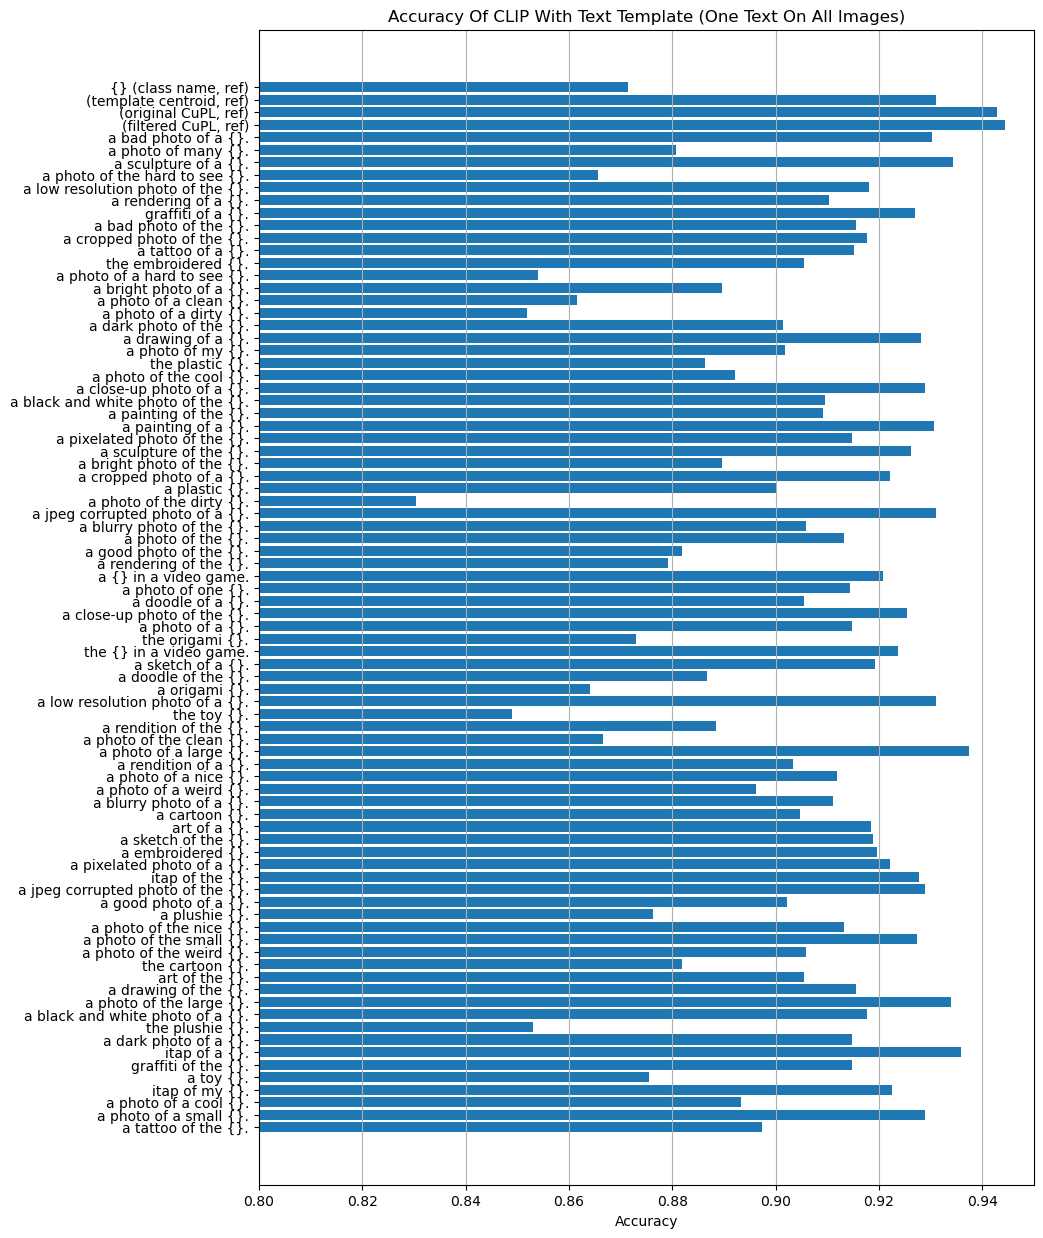

In [28]:
# @title Test Accuracy of Individual 80 Templates (With Class Name And 80 Templates (Centroid) As References)

# Include other accuracy results for reference
data = np.insert(template_text_individual_acc, 0, [cls_name_acc, template_cls_acc, original_cupl_cls_acc, filtered_cupl_cls_acc])

plt.figure(figsize=(10, 15))
plt.barh(np.arange(data.shape[0]), data)
plt.yticks(np.arange(len(template_text_individual_acc)+4), ['{} (class name, ref)', '(template centroid, ref)', '(original CuPL, ref)', '(filtered CuPL, ref)']+imagenet_templates)
plt.xlabel('Accuracy')
plt.title('Accuracy Of CLIP With Text Template (One Text On All Images)')
scale = 0.05
plt.xlim(int(data.min()/scale)*scale, (int(data.max()/scale)+1)*scale)
plt.grid(axis='x')
plt.gca().invert_yaxis()
plt.show()

# **Analyze Feature Similarity**

## Define the Functions

In [29]:
def print_top_pairs(similarity, text, *, top=10, xlabel='', ylabel='', coordinates=None):
    # Get the indices of top values
    top_indices = np.unravel_index(np.argsort(-similarity, axis=None)[:top], similarity.shape)

    # Extract the class names and labels for top values
    for idx, (label1, label2) in enumerate(zip(*top_indices)):
        if coordinates is None:
            print(f'Rank {idx+1}: ({label1}){ylabel}{cls_names_sorted[label1]} - ({label2}){xlabel}{cls_names_sorted[label2]}, {text}: {similarity[label1, label2]}')
        else:
            print(f'Rank {idx+1}: ({label1}){ylabel}{cls_names_sorted[label1]}(coor={coordinates[label1][0]:.0f},{coordinates[label1][1]:.0f}) - ({label2}){xlabel}{cls_names_sorted[label2]}(coor={coordinates[label1][0]:.0f},{coordinates[label1][1]:.0f}), {text}: {similarity[label1, label2]}')

In [30]:
def plot_cm(cm, title):
    plt.figure(figsize=(12, 10))
    plt.imshow(cm)
    plt.xticks(np.arange(0, cm.shape[0], 5))
    plt.yticks(np.arange(0, cm.shape[1], 5))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

In [31]:
def plot_similarity(similarity, title, xlabel=None, ylabel=None):
    plt.figure(figsize=(12, 10))
    plt.imshow(similarity)
    plt.xticks(np.arange(0, similarity.shape[0], 5))
    plt.yticks(np.arange(0, similarity.shape[1], 5))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.colorbar()
    plt.title(title)
    plt.show()

In [32]:
def visualize_auto_similarity(masked_similarity, cm, title):
    title_similarity = title + ' Similarity'
    print(f'{title_similarity.capitalize()} mean: {np.nanmean(masked_similarity)}')
    print(f'{title_similarity.capitalize()} std: {np.nanstd(masked_similarity)}')
    print_top_pairs(np.triu(masked_similarity, k=1), 'similarity')
    plot_similarity(masked_similarity, title_similarity)
    masked_cm = cm.copy()
    np.fill_diagonal(masked_cm, np.nan)
    print_top_pairs(masked_cm, 'error rate', top=20, xlabel='(pred)', ylabel=f'(true)')
    plot_cm(cm, title + ' Confusion Matrix')

In [33]:
def visualize_cross_similarity(similarity, cm, title, xlabel='Text', ylabel='Image'):
    title_similarity = title + ' Similarity'
    print(f'{title_similarity.capitalize()} mean: {np.mean(similarity)}')
    print(f'{title_similarity.capitalize()} std: {np.std(similarity)}')
    diagonal_similarity = similarity.diagonal()
    print(f'{title_similarity.capitalize()} diagonal mean: {np.mean(diagonal_similarity)}')
    print(f'{title_similarity.capitalize()} diagonal std: {np.std(diagonal_similarity)}')
    masked_similarity = similarity.copy()
    np.fill_diagonal(masked_similarity, np.nan)
    print(f'{title_similarity.capitalize()} non-diagonal mean: {np.nanmean(masked_similarity)}')
    print(f'{title_similarity.capitalize()} non-diagonal std: {np.nanstd(masked_similarity)}')
    print(f'{title_similarity.capitalize()} diagonal mean to non-diagonal mean ratio: {np.mean(diagonal_similarity)/np.nanmean(masked_similarity)}')
    print_top_pairs(masked_similarity, 'similarity', top=20, xlabel=f'({xlabel})', ylabel=f'({ylabel})')
    plot_similarity(similarity, title_similarity, xlabel=xlabel, ylabel=ylabel)
    masked_cm = cm.copy()
    np.fill_diagonal(masked_cm, np.nan)
    print_top_pairs(masked_cm, 'error rate', top=20, xlabel='(pred)', ylabel=f'(true)')
    plot_cm(cm, title + ' Confusion Matrix')

In [34]:
def calc_features_similarity(img_features_cuda, text_features_cuda):
    # img_features_cuda: list size (num_classes), with cuda tensors shape (('n_imgs'), 512)
    with torch.no_grad():
        similarity_cuda = []
        for img_embeddings in img_features_cuda:    # For imgs in each class
            if type(text_features_cuda) == list:
                # list size (num_classes) of cuda tensors shape (texts in the class, 512)
                # Calc cosine similarity of each image in the class with each text in the class, then take the mean
                similarity_cuda.append(torch.Tensor([(img_embeddings @ text_embeddings.T).mean() for text_embeddings in text_features_cuda]))
            else:
                # cuda tensor of shape (num_classes, 512)
                # Calc cosine similarity of each image in the class with the centroid of the class
                similarity_cuda.append((img_embeddings @ text_features_cuda.T).mean(dim=0))

        return torch.vstack(similarity_cuda).cpu().numpy()

In [35]:
def visualize_feature_similarity(visualization_type):
    match visualization_type:
        case 'Similarity Of Classes (Class Name)':
            visualize_auto_similarity(cls_name_masked_similarity, cls_name_cm, 'Class Name')
        case 'Similarity Of Classes (80 Templates)':
            visualize_auto_similarity(template_masked_similarity, template_cls_cm, 'Text Template')
        case 'Similarity Of Classes (Original CuPL)':
            visualize_auto_similarity(original_cupl_masked_similarity, original_cupl_cls_cm, 'Original CuPL Text')
        case 'Similarity Of Classes (Filtered CuPL)':
            visualize_auto_similarity(filtered_cupl_masked_similarity, filtered_cupl_cls_cm, 'Filtered CuPL Text')
        case 'Similarity Of Classes (Image)':
            visualize_auto_similarity(img_masked_similarity, 'Image')
        case 'Similarity Of Classes (Image vs Class Name) And Confusion Matrix':
            visualize_cross_similarity(calc_features_similarity(img_features_cuda, cls_name_features_cuda), cls_name_cm, 'Image To Class Name')
        case 'Similarity Of Classes (Image vs Centroid Of 80 Templates) And Confusion Matrix':
            visualize_cross_similarity(calc_features_similarity(img_features_cuda, template_cls_features_cuda), template_cls_cm, 'Image To Text Template (Centroid)')
        case 'Similarity Of Classes (Image vs Each 80 Templates Then Average) And Confusion Matrix':
            visualize_cross_similarity(calc_features_similarity(img_features_cuda, template_text_features_cuda), template_text_cm, 'Image To Text Template (Individual Avg)')
        case 'Similarity Of Classes (Image vs Centroid Of Original CuPL) And Confusion Matrix':
            visualize_cross_similarity(calc_features_similarity(img_features_cuda, original_cupl_cls_features_cuda), original_cupl_cls_cm, 'Image To Original CuPL Text (Centroid)')
        case 'Similarity Of Classes (Image vs Each Original CuPL Then Average) And Confusion Matrix':
            visualize_cross_similarity(calc_features_similarity(img_features_cuda, original_cupl_text_features_cuda), original_cupl_text_cm, 'Image To Original CuPL Text (Individual Avg)')
        case 'Similarity Of Classes (Image vs Centroid Of Filtered CuPL) And Confusion Matrix':
            visualize_cross_similarity(calc_features_similarity(img_features_cuda, filtered_cupl_cls_features_cuda), filtered_cupl_cls_cm, 'Image To Filtered CuPL Text (Centroid)')
        case 'Similarity Of Classes (Image vs Each Filtered CuPL Then Average) And Confusion Matrix':
            visualize_cross_similarity(calc_features_similarity(img_features_cuda, filtered_cupl_text_features_cuda), filtered_cupl_text_cm, 'Image To Filtered CuPL Text (Individual Avg)')

## Visualizations

Filtered cupl text similarity mean: 0.66943359375
Filtered cupl text similarity std: 0.08953857421875
Rank 1: (27)crocodile - (28)crocodile_head, similarity: 0.9716796875
Rank 2: (23)cougar_body - (24)cougar_face, similarity: 0.9619140625
Rank 3: (40)flamingo - (41)flamingo_head, similarity: 0.91748046875
Rank 4: (54)ketch - (78)schooner, similarity: 0.91357421875
Rank 5: (26)crayfish - (58)lobster, similarity: 0.91357421875
Rank 6: (25)crab - (58)lobster, similarity: 0.90771484375
Rank 7: (23)cougar_body - (96)wild_cat, similarity: 0.90771484375
Rank 8: (35)elephant - (75)rhino, similarity: 0.89990234375
Rank 9: (59)lotus - (94)water_lilly, similarity: 0.89794921875
Rank 10: (24)cougar_face - (96)wild_cat, similarity: 0.89794921875


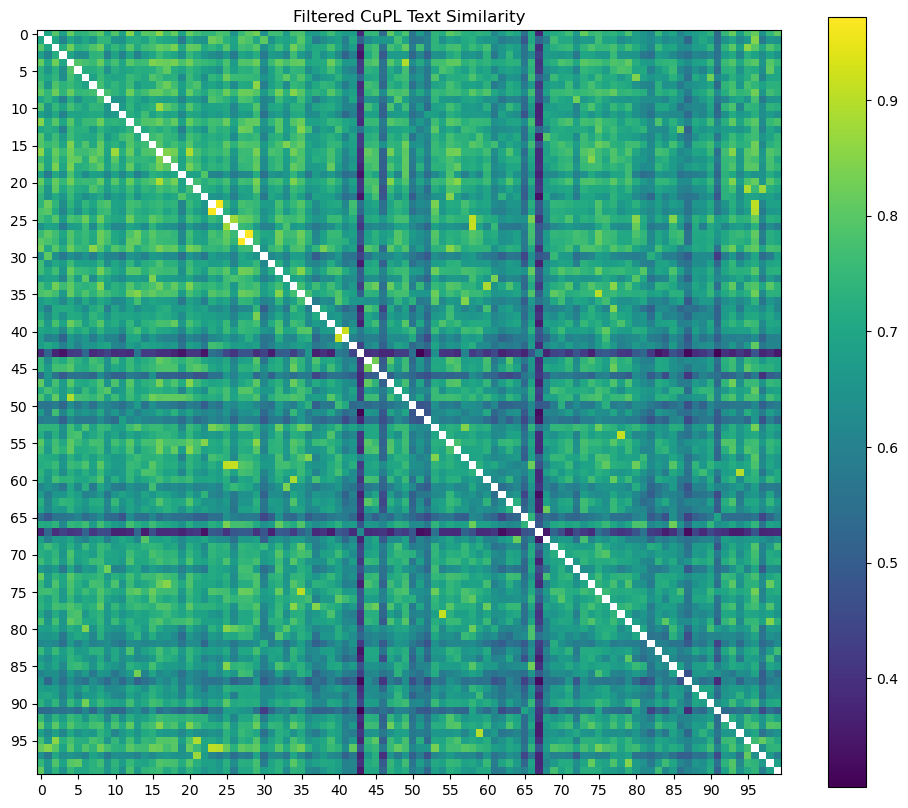

Rank 1: (28)(true)crocodile_head - (27)(pred)crocodile, error rate: 0.8
Rank 2: (21)(true)chair - (97)(pred)windsor_chair, error rate: 0.631578947368421
Rank 3: (54)(true)ketch - (78)(pred)schooner, error rate: 0.47058823529411764
Rank 4: (96)(true)wild_cat - (1)(pred)leopard, error rate: 0.4
Rank 5: (59)(true)lotus - (94)(pred)water_lilly, error rate: 0.35
Rank 6: (58)(true)lobster - (26)(pred)crayfish, error rate: 0.3076923076923077
Rank 7: (41)(true)flamingo_head - (40)(pred)flamingo, error rate: 0.2857142857142857
Rank 8: (78)(true)schooner - (54)(pred)ketch, error rate: 0.2777777777777778
Rank 9: (33)(true)dragonfly - (61)(pred)mayfly, error rate: 0.25
Rank 10: (96)(true)wild_cat - (23)(pred)cougar_body, error rate: 0.2
Rank 11: (26)(true)crayfish - (58)(pred)lobster, error rate: 0.19047619047619047
Rank 12: (29)(true)cup - (38)(pred)ewer, error rate: 0.1111111111111111
Rank 13: (43)(true)gerenuk - (67)(pred)okapi, error rate: 0.1
Rank 14: (10)(true)binocular - (51)(pred)inline_sk

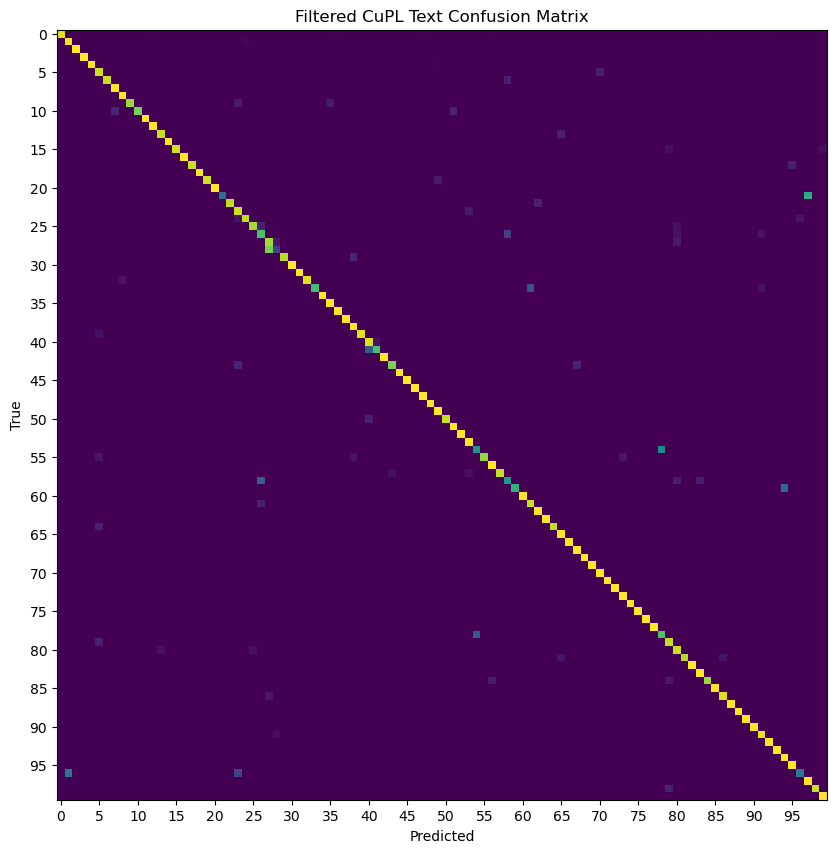

In [36]:
# @title Visualization 1

vis1 = 'Similarity Of Classes (Filtered CuPL)' #@param ['Similarity Of Classes (Class Name)', 'Similarity Of Classes (80 Templates)', 'Similarity Of Classes (Original CuPL)', 'Similarity Of Classes (Filtered CuPL)', 'Similarity Of Classes (Image)', 'Similarity Of Classes (Image vs Class Name) And Confusion Matrix', 'Similarity Of Classes (Image vs Centroid Of 80 Templates) And Confusion Matrix', 'Similarity Of Classes (Image vs Each 80 Templates Then Average) And Confusion Matrix', 'Similarity Of Classes (Image vs Centroid Of Original CuPL) And Confusion Matrix', 'Similarity Of Classes (Image vs Each Original CuPL Then Average) And Confusion Matrix', 'Similarity Of Classes (Image vs Centroid Of Filtered CuPL) And Confusion Matrix', 'Similarity Of Classes (Image vs Each Filtered CuPL Then Average) And Confusion Matrix']
# vis1 = 'Similarity Of Classes (Class Name)'
# vis1 = 'Similarity Of Classes (80 Templates)'
# vis1 = 'Similarity Of Classes (Original CuPL)'
# vis1 = 'Similarity Of Classes (Filtered CuPL)'
# vis1 = 'Similarity Of Classes (Image)'
# vis1 = 'Similarity Of Classes (Image vs Class Name) And Confusion Matrix'
# vis1 = 'Similarity Of Classes (Image vs Centroid Of 80 Templates) And Confusion Matrix'
# vis1 = 'Similarity Of Classes (Image vs Each 80 Templates Then Average) And Confusion Matrix'
# vis1 = 'Similarity Of Classes (Image vs Centroid Of Original CuPL) And Confusion Matrix'
# vis1 = 'Similarity Of Classes (Image vs Each Original CuPL Then Average) And Confusion Matrix'
# vis1 = 'Similarity Of Classes (Image vs Centroid Of Filtered CuPL) And Confusion Matrix'
# vis1 = 'Similarity Of Classes (Image vs Each Filtered CuPL Then Average) And Confusion Matrix'
visualize_feature_similarity(vis1)

Image to filtered cupl text (centroid) similarity mean: 0.195068359375
Image to filtered cupl text (centroid) similarity std: 0.0283355712890625
Image to filtered cupl text (centroid) similarity diagonal mean: 0.3330078125
Image to filtered cupl text (centroid) similarity diagonal std: 0.0183868408203125
Image to filtered cupl text (centroid) similarity non-diagonal mean: 0.1937255859375
Image to filtered cupl text (centroid) similarity non-diagonal std: 0.0247802734375
Image to filtered cupl text (centroid) similarity diagonal mean to non-diagonal mean ratio: 1.71875
Rank 1: (94)(Image)water_lilly - (59)(Text)lotus, similarity: 0.3349609375
Rank 2: (78)(Image)schooner - (54)(Text)ketch, similarity: 0.33349609375
Rank 3: (28)(Image)crocodile_head - (27)(Text)crocodile, similarity: 0.333251953125
Rank 4: (41)(Image)flamingo_head - (40)(Text)flamingo, similarity: 0.330810546875
Rank 5: (40)(Image)flamingo - (41)(Text)flamingo_head, similarity: 0.330322265625
Rank 6: (54)(Image)ketch - (7

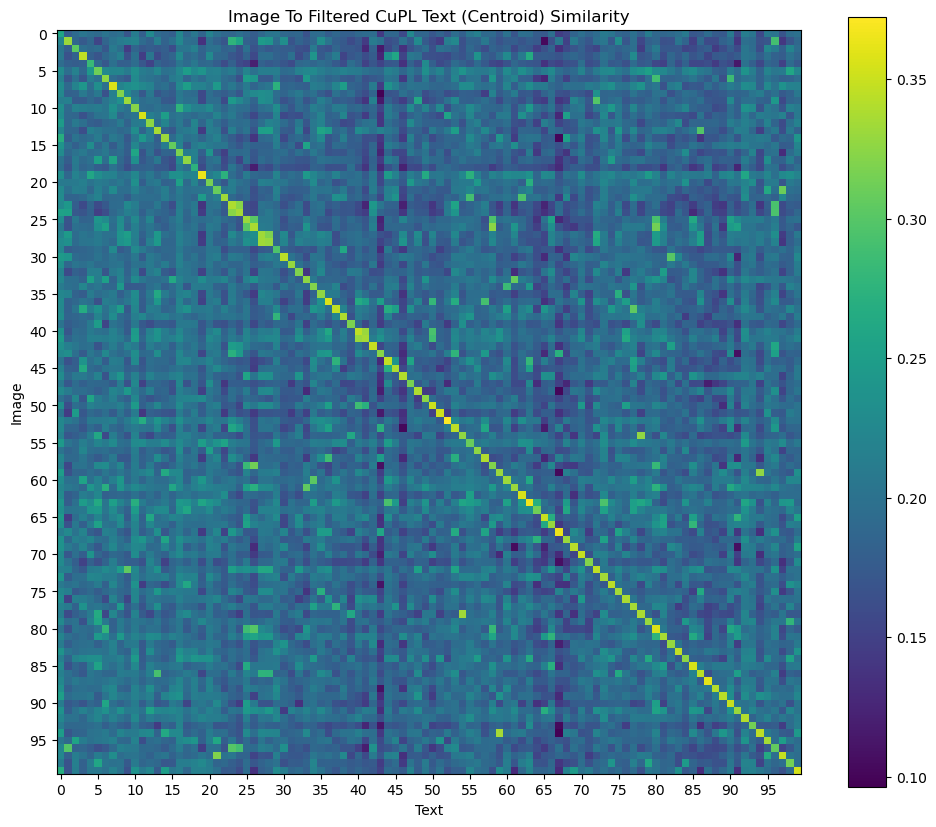

Rank 1: (28)(true)crocodile_head - (27)(pred)crocodile, error rate: 0.8
Rank 2: (21)(true)chair - (97)(pred)windsor_chair, error rate: 0.631578947368421
Rank 3: (54)(true)ketch - (78)(pred)schooner, error rate: 0.47058823529411764
Rank 4: (96)(true)wild_cat - (1)(pred)leopard, error rate: 0.4
Rank 5: (59)(true)lotus - (94)(pred)water_lilly, error rate: 0.35
Rank 6: (58)(true)lobster - (26)(pred)crayfish, error rate: 0.3076923076923077
Rank 7: (41)(true)flamingo_head - (40)(pred)flamingo, error rate: 0.2857142857142857
Rank 8: (78)(true)schooner - (54)(pred)ketch, error rate: 0.2777777777777778
Rank 9: (33)(true)dragonfly - (61)(pred)mayfly, error rate: 0.25
Rank 10: (96)(true)wild_cat - (23)(pred)cougar_body, error rate: 0.2
Rank 11: (26)(true)crayfish - (58)(pred)lobster, error rate: 0.19047619047619047
Rank 12: (29)(true)cup - (38)(pred)ewer, error rate: 0.1111111111111111
Rank 13: (43)(true)gerenuk - (67)(pred)okapi, error rate: 0.1
Rank 14: (10)(true)binocular - (51)(pred)inline_sk

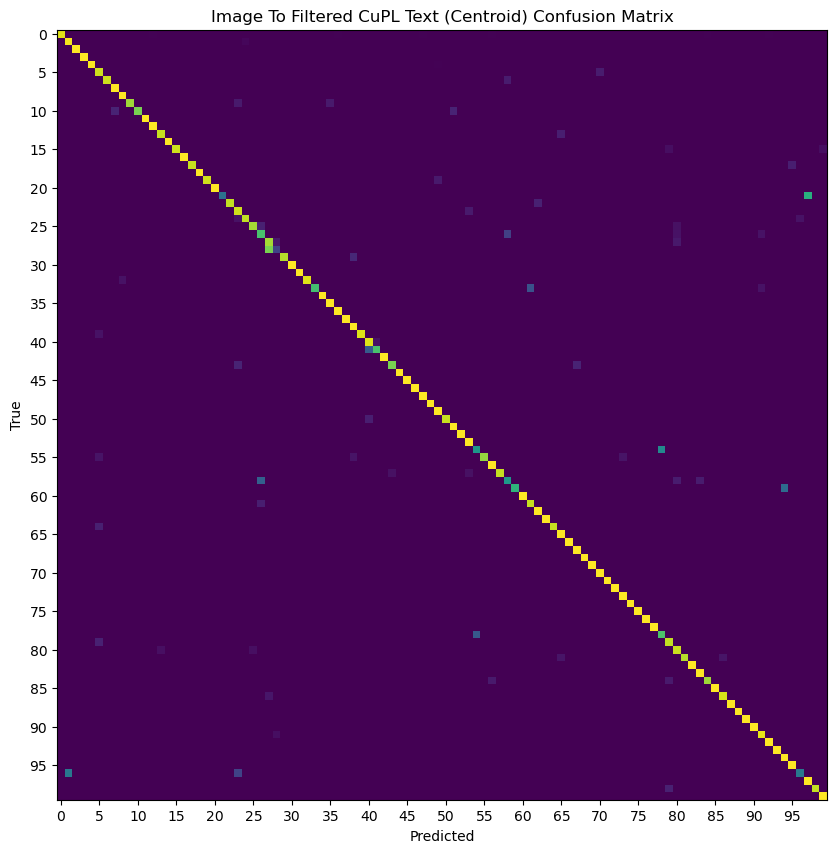

In [37]:
# @title Visualization 2

vis2 = 'Similarity Of Classes (Image vs Centroid Of Filtered CuPL) And Confusion Matrix' #@param ['Similarity Of Classes (Class Name)', 'Similarity Of Classes (80 Templates)', 'Similarity Of Classes (Original CuPL)', 'Similarity Of Classes (Filtered CuPL)', 'Similarity Of Classes (Image)', 'Similarity Of Classes (Image vs Class Name) And Confusion Matrix', 'Similarity Of Classes (Image vs Centroid Of 80 Templates) And Confusion Matrix', 'Similarity Of Classes (Image vs Each 80 Templates Then Average) And Confusion Matrix', 'Similarity Of Classes (Image vs Centroid Of Original CuPL) And Confusion Matrix', 'Similarity Of Classes (Image vs Each Original CuPL Then Average) And Confusion Matrix', 'Similarity Of Classes (Image vs Centroid Of Filtered CuPL) And Confusion Matrix', 'Similarity Of Classes (Image vs Each Filtered CuPL Then Average) And Confusion Matrix']
# vis2 = 'Similarity Of Classes (Class Name)'
# vis2 = 'Similarity Of Classes (80 Templates)'
# vis2 = 'Similarity Of Classes (Original CuPL)'
# vis2 = 'Similarity Of Classes (Filtered CuPL)'
# vis2 = 'Similarity Of Classes (Image)'
# vis2 = 'Similarity Of Classes (Image vs Class Name) And Confusion Matrix'
# vis2 = 'Similarity Of Classes (Image vs Centroid Of 80 Templates) And Confusion Matrix'
# vis2 = 'Similarity Of Classes (Image vs Each 80 Templates Then Average) And Confusion Matrix'
# vis2 = 'Similarity Of Classes (Image vs Centroid Of Original CuPL) And Confusion Matrix'
# vis2 = 'Similarity Of Classes (Image vs Each Original CuPL Then Average) And Confusion Matrix'
# vis2 = 'Similarity Of Classes (Image vs Centroid Of Filtered CuPL) And Confusion Matrix'
# vis2 = 'Similarity Of Classes (Image vs Each Filtered CuPL Then Average) And Confusion Matrix'
visualize_feature_similarity(vis2)

In [38]:
# @title Diff Of Improvements Using Filtered CuPL

# Choose what to diff
# diff1 = cls_name_pred
# diff1 = template_cls_pred
diff1 = original_cupl_cls_pred
diff2 = filtered_cupl_cls_pred
for idx in np.squeeze(np.nonzero(diff1 != diff2)):
    if diff2[idx] == img_label_ids[idx]:
        print(f'{idx}: Img#{img_to_idx[idx]}: ({img_label_ids[idx]}){cls_names_sorted[img_label_ids[idx]]}: ({diff1[idx]}){cls_names_sorted[diff1[idx]]} -> ({diff2[idx]}){cls_names_sorted[diff2[idx]]} (correct)')
    elif diff1[idx] == img_label_ids[idx]:
        print(f'{idx}: Img#{img_to_idx[idx]}: ({img_label_ids[idx]}){cls_names_sorted[img_label_ids[idx]]}: ({diff1[idx]}){cls_names_sorted[diff1[idx]]} -> ({diff2[idx]}){cls_names_sorted[diff2[idx]]} (wrong)')

102: Img#102: (0)face: (52)joshua_tree -> (0)face (correct)
634: Img#634: (4)airplane: (4)airplane -> (49)helicopter (wrong)
734: Img#734: (8)bass: (46)hawksbill -> (8)bass (correct)
1099: Img#1099: (26)crayfish: (58)lobster -> (26)crayfish (correct)
1628: Img#1628: (54)ketch: (54)ketch -> (78)schooner (wrong)
1632: Img#1632: (54)ketch: (54)ketch -> (78)schooner (wrong)
1635: Img#1635: (54)ketch: (54)ketch -> (78)schooner (wrong)
1638: Img#1638: (54)ketch: (54)ketch -> (78)schooner (wrong)
1650: Img#1650: (54)ketch: (54)ketch -> (78)schooner (wrong)
1655: Img#1655: (54)ketch: (54)ketch -> (78)schooner (wrong)
1992: Img#1992: (75)rhino: (35)elephant -> (75)rhino (correct)
2034: Img#2034: (78)schooner: (54)ketch -> (78)schooner (correct)
2039: Img#2039: (78)schooner: (54)ketch -> (78)schooner (correct)
2135: Img#2135: (84)stapler: (51)inline_skate -> (84)stapler (correct)
2268: Img#2268: (91)trilobite: (91)trilobite -> (28)crocodile_head (wrong)
2380: Img#2380: (94)water_lilly: (59)lotus

# **Visualization of Features Using t-SNE**

## Dimensionality Reduction Using t-SNE

In [39]:
# Concatenate all features and labels to be used for plotting
all_label_ids = np.concatenate([cls_name_label_ids, template_label_ids, original_cupl_label_ids, filtered_cupl_label_ids])
all_features = np.concatenate([cls_name_features, template_text_features, original_cupl_text_features, filtered_cupl_text_features])

cls_name_start_idx = 0
cls_name_end_idx = len(cls_name_features)
template_start_idx = len(cls_name_features)
template_end_idx = len(cls_name_features) + len(template_text_features)
original_cupl_start_idx = len(cls_name_features) + len(template_text_features)
original_cupl_end_idx = len(cls_name_features) + len(template_text_features) + len(original_cupl_text_features)
filtered_cupl_start_idx = len(cls_name_features) + len(template_text_features) + len(original_cupl_text_features)
filtered_cupl_end_idx = len(cls_name_features) + len(template_text_features) + len(original_cupl_text_features) + len(filtered_cupl_text_features)

In [40]:
# Fit t-SNE
# High perplexity is better to visualize distence between clusters
tsne = sklearn.manifold.TSNE(n_components=2, random_state=42, metric='cosine', perplexity=100)
transformed_features = tsne.fit_transform(all_features)

In [41]:
def calc_centroid(features, label_ids):
    # Calc centroid of each class
    # return list size (num_classes), each containing the centroid of the class
    return [features[label_ids == label_id].mean(axis=0) for label_id in range(len(cls_names_sorted))]

In [42]:
cls_name_transformed_features = transformed_features[cls_name_start_idx:cls_name_end_idx]
cls_name_transformed_label_ids = all_label_ids[cls_name_start_idx:cls_name_end_idx]
cls_name_transformed_centroids = calc_centroid(cls_name_transformed_features, cls_name_transformed_label_ids)
template_transformed_features = transformed_features[template_start_idx:template_end_idx]
template_transformed_label_ids = all_label_ids[template_start_idx:template_end_idx]
template_transformed_centroids = calc_centroid(template_transformed_features, template_transformed_label_ids)
original_cupl_transformed_features = transformed_features[original_cupl_start_idx:original_cupl_end_idx]
original_cupl_transformed_label_ids = all_label_ids[original_cupl_start_idx:original_cupl_end_idx]
original_cupl_transformed_centroids = calc_centroid(original_cupl_transformed_features, original_cupl_transformed_label_ids)
filtered_cupl_transformed_features = transformed_features[filtered_cupl_start_idx:filtered_cupl_end_idx]
filtered_cupl_transformed_label_ids = all_label_ids[filtered_cupl_start_idx:filtered_cupl_end_idx]
filtered_cupl_transformed_centroids = calc_centroid(filtered_cupl_transformed_features, filtered_cupl_transformed_label_ids)

In [43]:
def plot_features_2d(features, label_ids, title):
    plt.figure(figsize=(10, 10))
    plt.scatter(features[:, 0], features[:, 1], c=label_ids, cmap='hsv')
    for label_id in range(len(cls_names_sorted)):
        plt.annotate(label_id, (features[label_ids == label_id, 0].mean(), features[label_ids == label_id, 1].mean()), ha='center', va='center', fontsize=12)
    plt.title(title)
    plt.show()

In [44]:
def visualize_tsne(visualization_type):
    match visualization_type:
        case 'Class Name Text Features':
            print_top_pairs(np.triu(cls_name_masked_similarity, k=1), 'similarity', coordinates=cls_name_transformed_centroids)
            plot_features_2d(cls_name_transformed_features, cls_name_transformed_label_ids, 'Class Name')
        case '80 Templates Text Features':
            print_top_pairs(np.triu(template_masked_similarity, k=1), 'similarity', coordinates=template_transformed_centroids)
            plot_features_2d(template_transformed_features, template_transformed_label_ids, 'Text Template')
        case 'Original CuPL Text Features':
            print_top_pairs(np.triu(original_cupl_masked_similarity, k=1), 'similarity', coordinates=original_cupl_transformed_centroids)
            plot_features_2d(original_cupl_transformed_features, original_cupl_transformed_label_ids, 'Original CuPL Text')
        case 'Filtered CuPL Text Features':
            print_top_pairs(np.triu(filtered_cupl_masked_similarity, k=1), 'similarity', coordinates=filtered_cupl_transformed_centroids)
            plot_features_2d(filtered_cupl_transformed_features, filtered_cupl_transformed_label_ids, 'Filtered CuPL Text')

## Visualizations

Rank 1: (27)crocodile(coor=-10,-16) - (28)crocodile_head(coor=-10,-16), similarity: 0.9716796875
Rank 2: (23)cougar_body(coor=-3,-43) - (24)cougar_face(coor=-3,-43), similarity: 0.96142578125
Rank 3: (40)flamingo(coor=-65,8) - (41)flamingo_head(coor=-65,8), similarity: 0.9169921875
Rank 4: (54)ketch(coor=1,-19) - (78)schooner(coor=1,-19), similarity: 0.9150390625
Rank 5: (26)crayfish(coor=-23,31) - (58)lobster(coor=-23,31), similarity: 0.9111328125
Rank 6: (23)cougar_body(coor=-3,-43) - (96)wild_cat(coor=-3,-43), similarity: 0.908203125
Rank 7: (25)crab(coor=-27,26) - (58)lobster(coor=-27,26), similarity: 0.90576171875
Rank 8: (24)cougar_face(coor=-2,-44) - (96)wild_cat(coor=-2,-44), similarity: 0.89990234375
Rank 9: (59)lotus(coor=-25,52) - (94)water_lilly(coor=-25,52), similarity: 0.8984375
Rank 10: (35)elephant(coor=-30,-18) - (75)rhino(coor=-30,-18), similarity: 0.89794921875


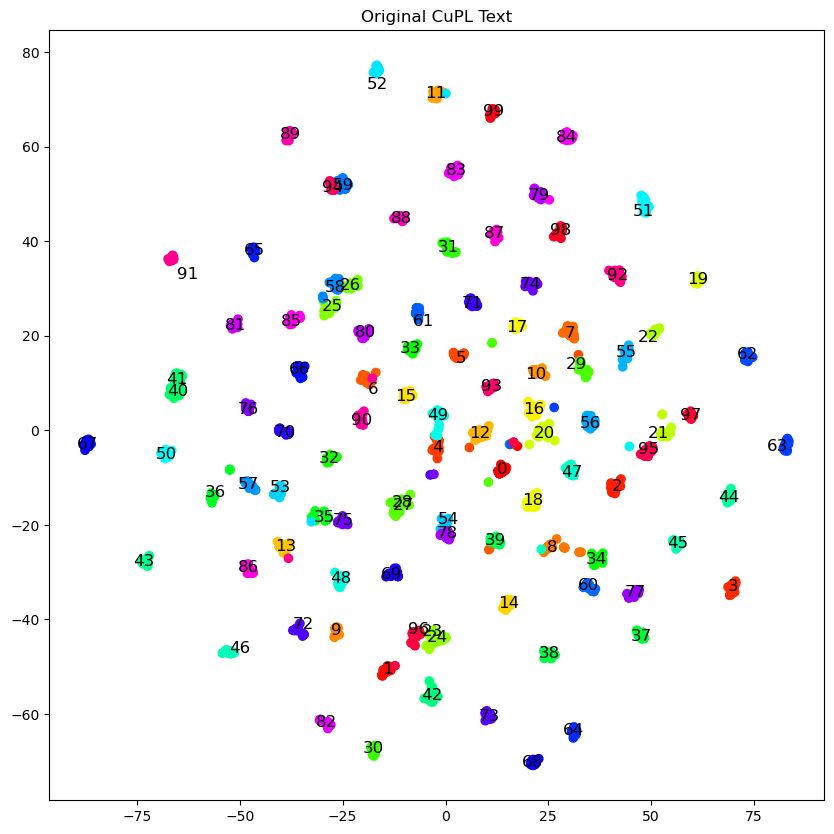

In [45]:
# @title Visualization 1

vis1 = 'Original CuPL Text Features'    #@param ['Class Name Text Features', '80 Templates Text Features', 'Original CuPL Text Features', 'Filtered CuPL Text Features']
# vis1 = 'Class Name Text Features'
# vis1 = '80 Templates Text Features'
# vis1 = 'Original CuPL Text Features'
# vis1 = 'Filtered CuPL Text Features'
visualize_tsne(vis1)

Rank 1: (27)crocodile(coor=-10,-16) - (28)crocodile_head(coor=-10,-16), similarity: 0.9716796875
Rank 2: (23)cougar_body(coor=-3,-42) - (24)cougar_face(coor=-3,-42), similarity: 0.9619140625
Rank 3: (40)flamingo(coor=-65,8) - (41)flamingo_head(coor=-65,8), similarity: 0.91748046875
Rank 4: (54)ketch(coor=0,-19) - (78)schooner(coor=0,-19), similarity: 0.91357421875
Rank 5: (26)crayfish(coor=-23,31) - (58)lobster(coor=-23,31), similarity: 0.91357421875
Rank 6: (25)crab(coor=-27,26) - (58)lobster(coor=-27,26), similarity: 0.90771484375
Rank 7: (23)cougar_body(coor=-3,-42) - (96)wild_cat(coor=-3,-42), similarity: 0.90771484375
Rank 8: (35)elephant(coor=-29,-18) - (75)rhino(coor=-29,-18), similarity: 0.89990234375
Rank 9: (59)lotus(coor=-25,52) - (94)water_lilly(coor=-25,52), similarity: 0.89794921875
Rank 10: (24)cougar_face(coor=-2,-44) - (96)wild_cat(coor=-2,-44), similarity: 0.89794921875


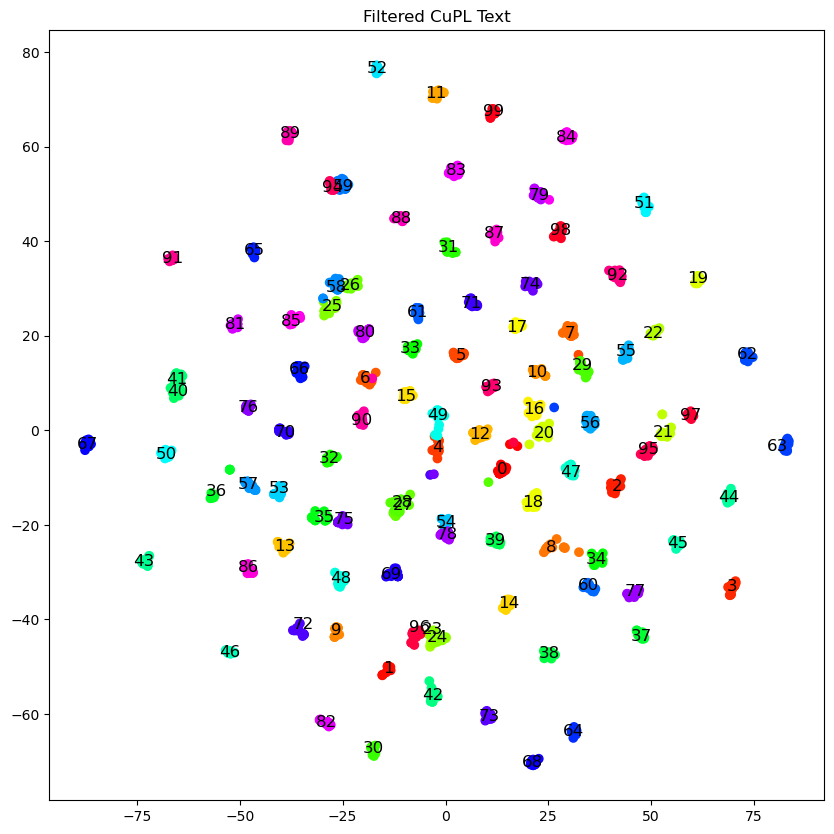

In [46]:
# @title Visualization 2

vis2 = 'Filtered CuPL Text Features'    #@param ['Class Name Text Features', '80 Templates Text Features', 'Original CuPL Text Features', 'Filtered CuPL Text Features']
# vis2 = 'Class Name Text Features'
# vis2 = '80 Templates Text Features'
# vis2 = 'Original CuPL Text Features'
# vis2 = 'Filtered CuPL Text Features'
visualize_tsne(vis2)